# Defs and loads

In [1]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import partridge as ptg
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"}) 

parent = Path('..','data')
dynamic_path = parent / 'dynamic_gtfs'
static_path = parent / 'static_gtfs'

In [2]:
train_day = '20251010'
test_day = '20251011'

df_train = pd.read_csv(dynamic_path / 'delays' / f'{train_day}.csv',header=0)
df_test  = pd.read_csv(dynamic_path / 'delays' / f'{test_day}.csv',header=0)

len(df_train), len(df_test)

(24336, 9115)

In [3]:
display(df_train.loc[df_train['delay'].idxmin()])
display(df_train.loc[df_train['delay'].idxmax()])

route_id            1660
trip_id       D020722246
delay               -891
trip_start         59280
Name: 16230, dtype: object

route_id             2100
trip_id       D0345812379
delay                 899
trip_start          54540
Name: 19666, dtype: object

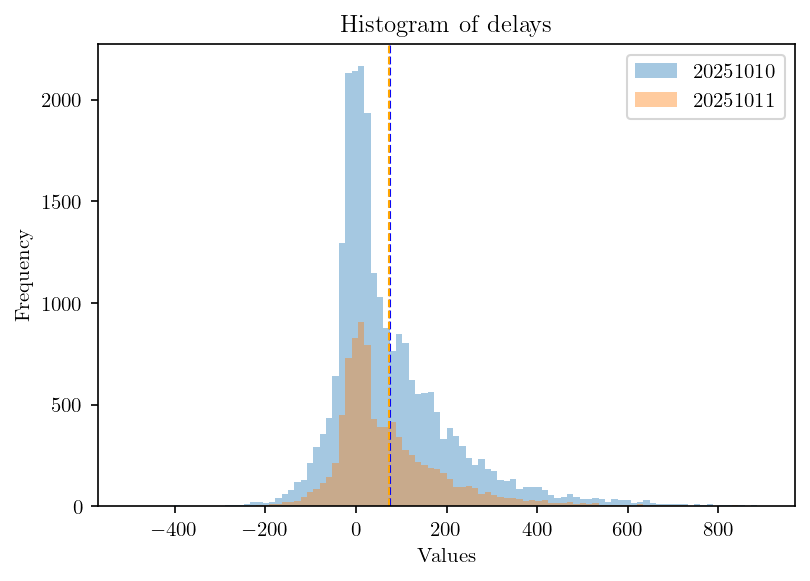

In [4]:
plt.figure(figsize=(6,4),dpi=150)

plt.hist(df_train["delay"], bins=100, range=(-500, 900),alpha=0.4, label=train_day)
plt.hist(df_test["delay"], bins=100, range=(-500, 900),alpha=0.4, label=test_day)

plt.axvline(df_train["delay"].mean(), color="blue", linestyle="--", linewidth=1)
plt.axvline(df_test["delay"].mean(),  color="orange", linestyle="--", linewidth=1)

plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title(f"Histogram of delays")
plt.legend()
plt.show()

In [5]:
# MODELS
class PeriodRouteModel:

    """
    A napszak és a route figyelembevételével becsül átlag késést
    """
    
    def __init__(self, bins):
        self.labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
        self.bins = [b*60*60 for b in bins]

    def fit(self,df):
        df = df.copy()
        df["period"] = pd.cut(df['trip_start'],bins=self.bins,labels=self.labels)

        self.model = (
            df.groupby(["period", "route_id"], observed=False)["delay"]
            .mean()
            .dropna()
            .to_dict()
        )
    
    def evaluate(self,df):
        df = df.copy()
        df["period"] = pd.cut(df['trip_start'],bins=self.bins,labels=self.labels)

        df["pred_delay"] = df.apply(
            lambda r: self.model.get((r["period"], r["route_id"])),
            axis=1
        ).fillna(0)

        rmse = np.sqrt(mean_squared_error(df["delay"], df["pred_delay"]))
        mae = mean_absolute_error(df["delay"], df["pred_delay"])

        return rmse, mae


class RouteModel:
    
    """
    A route figyelembevételével becsül átlag késést
    """

    def __init__(self):
        pass

    def fit(self,df):
        df = df.copy()
        self.model = (
            df.groupby(["route_id"], observed=False)["delay"]
            .mean()
            .dropna()
            .to_dict()
        )
    
    def evaluate(self,df):
        df = df.copy()
        df["pred_delay"] = df.apply(
            lambda r: self.model.get(r["route_id"]),
            axis=1
        ).fillna(0)

        rmse = np.sqrt(mean_squared_error(df["delay"], df["pred_delay"]))
        mae = mean_absolute_error(df["delay"], df["pred_delay"])

        return rmse, mae

In [6]:
model = PeriodRouteModel(bins=[0,6,9,15,18,24])
model.fit(df_train)
model.evaluate(df_test)

(123.52797191358891, 87.06039775758472)

In [7]:
model = PeriodRouteModel(bins=[0,8,16,24])
model.fit(df_train)
model.evaluate(df_test)

(124.61383528654501, 88.41102996881226)

In [8]:
model = RouteModel()
model.fit(df_train)
model.evaluate(df_test)

(125.59899235345281, 88.8458518947327)

# MLP baseline

In [38]:
train_day = '20251010'
test_day = '20251011'

records_train = pd.read_csv(dynamic_path / 'records' / f'{train_day}.csv',header=0,low_memory=False)
records_test  = pd.read_csv(dynamic_path / 'records' / f'{test_day}.csv',header=0,low_memory=False)
delays_train = pd.read_csv(dynamic_path / 'delays' / f'{train_day}.csv',header=0)
delays_test  = pd.read_csv(dynamic_path / 'delays' / f'{test_day}.csv',header=0)

trips_train = list(delays_train['trip_id'])
len(records_train), len(records_test), len(delays_train), len(delays_test)

(1035773, 405933, 24336, 9115)

In [39]:
trips_train = list(delays_train['trip_id'])

In [48]:
from src.utils.time import timestamp_to_seconds, timestamp_to_day

records_train['sec'] = records_train['timestamp'].apply(timestamp_to_seconds)
records_train['ts'] = pd.to_datetime(records_train['timestamp'], unit='s')

In [ ]:
def summarize(trip):
    return pd.Series({
        'avg_timediff': trip['ts'].diff().dt.total_seconds().mean(),
        'num_points': len(trip),
        'avg_latitude': trip['latitude'].mean(),
        'avg_longitude': trip['longitude'].mean(),
        'start_lat': trip['latitude'].iloc[0],
        'start_lon': trip['longitude'].iloc[0],
        'end_lat': trip['latitude'].iloc[-1],
        'end_lon': trip['longitude'].iloc[-1],
        'start_hour': trip['ts'].iloc[0].hour,
        'start_weekday': trip['ts'].iloc[0].isoweekday()  # Mon=1
    })

features = records_train.groupby('trip_id').apply(summarize)

/tmp/ipykernel_2050/3114480521.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inputs = records_train.groupby('trip_id').apply(summarize)


In [55]:
dataset = delays_train.merge(features, on='trip_id')

In [59]:
dataset

,route_id,trip_id,delay,trip_start,avg_timediff,num_points,avg_latitude,avg_longitude,start_lat,start_lon,end_lat,end_lon,start_hour,start_weekday
0,50,D01668436,114,83880,59.555556,10.0,47.513388,19.009938,47.504684,19.024683,47.523621,18.994280,21.0,4.0
1,50,D01668444,-38,85080,63.000000,26.0,47.501808,19.047565,47.508350,19.094648,47.523342,18.994822,22.0,4.0
2,50,D01668447,-68,83460,9.369942,174.0,47.566262,19.034290,47.566296,19.129232,47.567726,19.029167,22.0,4.0
3,50,D01668459,179,84660,62.291667,25.0,47.541991,19.113464,47.508766,19.095379,47.567406,19.124819,22.0,4.0
4,50,D01668461,-33,85860,61.416667,49.0,47.525747,19.089397,47.502075,19.027107,47.538418,19.069189,22.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24331,9990,C930534,-39,3780,59.285714,15.0,47.444428,19.142824,47.426651,19.161058,47.463890,19.127203,23.0,4.0
24332,9990,C930535,-15,4800,60.158537,83.0,47.435363,19.148607,47.465080,19.127306,47.428925,19.155117,23.0,4.0
24333,9990,C930536,-18,9780,59.945946,38.0,47.455790,19.133877,47.427864,19.156172,47.464123,19.127594,0.0,5.0
24334,9990,C930538,-38,13380,60.384615,14.0,47.445292,19.141773,47.426579,19.161158,47.464081,19.127447,1.0,5.0


In [93]:
import torch
from sklearn.preprocessing import StandardScaler

def preprocess(dataset, feature_cols, target_col='delays'):
    X = dataset[feature_cols].values.astype(float)
    y = dataset[target_col].values.astype(float).reshape(-1, 1)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # Convert to tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

    return X_tensor, y_tensor, scaler_X, scaler_y

In [94]:
import torch.nn as nn

class TripDelayMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[16, 16]):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(hidden_dims)):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dims[-1], 1))  # output: delay
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [95]:
def train_model(model, X, y, lr=1e-3, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())  # save loss
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    return losses

In [96]:
feature_cols = [
    'avg_timediff',
    'avg_latitude',
    'avg_longitude',
    'start_hour',
]

target_col = ['delay']

X_tensor, y_tensor, scaler_X, scaler_y = preprocess(dataset, feature_cols,target_col)
X_tensor = torch.nan_to_num(X_tensor, nan=0.0)

print(torch.isnan(X_tensor).any(), torch.isinf(X_tensor).any())
print(torch.isnan(y_tensor).any(), torch.isinf(y_tensor).any())

tensor(False) tensor(False)
tensor(False) tensor(False)


In [100]:
model = TripDelayMLP(input_dim=len(feature_cols), hidden_dims=[8, 8, 8])
losses = train_model(model, X_tensor, y_tensor, epochs=1000)

Epoch 0, Loss: 1.0231
Epoch 10, Loss: 1.0121
Epoch 20, Loss: 1.0048
Epoch 30, Loss: 0.9984
Epoch 40, Loss: 0.9932
Epoch 50, Loss: 0.9893
Epoch 60, Loss: 0.9865
Epoch 70, Loss: 0.9840
Epoch 80, Loss: 0.9813
Epoch 90, Loss: 0.9781
Epoch 100, Loss: 0.9747
Epoch 110, Loss: 0.9713
Epoch 120, Loss: 0.9679
Epoch 130, Loss: 0.9647
Epoch 140, Loss: 0.9621
Epoch 150, Loss: 0.9599
Epoch 160, Loss: 0.9580
Epoch 170, Loss: 0.9565
Epoch 180, Loss: 0.9553
Epoch 190, Loss: 0.9542
Epoch 200, Loss: 0.9532
Epoch 210, Loss: 0.9523
Epoch 220, Loss: 0.9515
Epoch 230, Loss: 0.9508
Epoch 240, Loss: 0.9502
Epoch 250, Loss: 0.9496
Epoch 260, Loss: 0.9491
Epoch 270, Loss: 0.9485
Epoch 280, Loss: 0.9480
Epoch 290, Loss: 0.9475
Epoch 300, Loss: 0.9469
Epoch 310, Loss: 0.9464
Epoch 320, Loss: 0.9458
Epoch 330, Loss: 0.9452
Epoch 340, Loss: 0.9445
Epoch 350, Loss: 0.9439
Epoch 360, Loss: 0.9432
Epoch 370, Loss: 0.9426
Epoch 380, Loss: 0.9419
Epoch 390, Loss: 0.9412
Epoch 400, Loss: 0.9406
Epoch 410, Loss: 0.9400
Epo

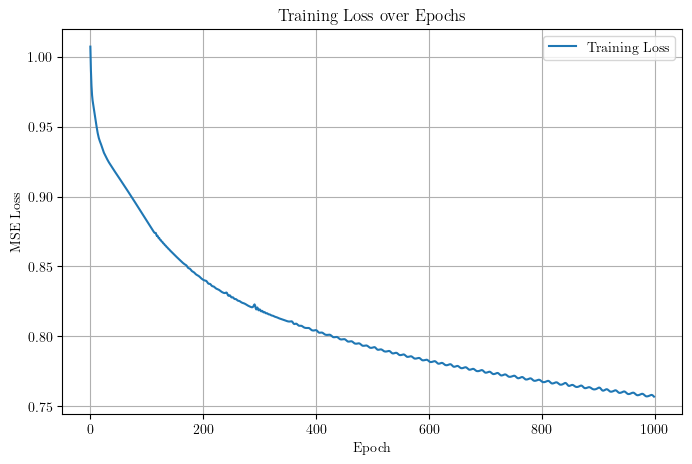

In [92]:
import matplotlib.pyplot as plt

# Suppose 'losses' is your list of loss values per epoch
plt.figure(figsize=(8,5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()